<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #2: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ARIMA models and getting aqcuainted with statistical time series analysis in python.

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (5%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_cunsumption.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ5by4qa_HFqAAoYIg'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot each time series
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import statsmodels.api as sm
from scipy import stats


from utils import qualityRMSE, qualityMedianAE
from utils import ExponentialSmoothing

%matplotlib inline

In [70]:
ts_mw = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)

ts_en = pd.read_csv('./data/energy_consump.csv', sep=',', decimal='.', index_col='Date', parse_dates=True, dayfirst=True)

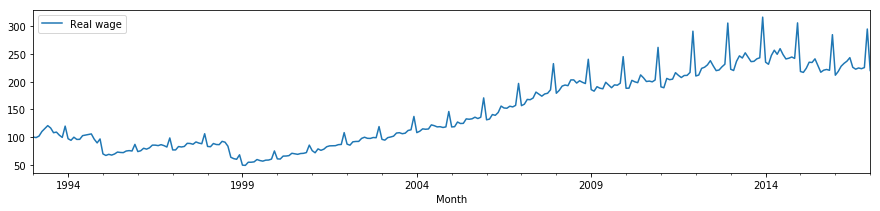

In [71]:
ts_mw.plot(figsize = (15,3))

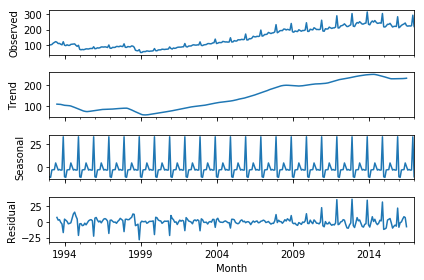

In [72]:
res = sm.tsa.seasonal_decompose(ts_mw)
resplot = res.plot()

In monthly-wage TS seasonality period is 1 year

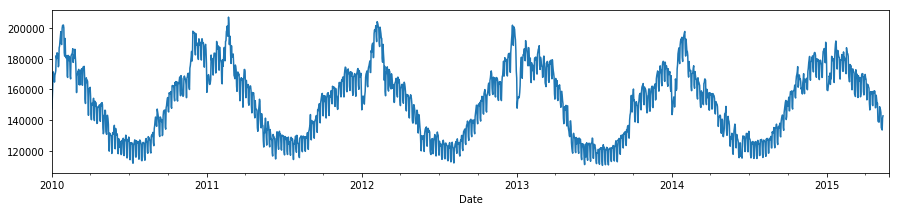

In [73]:
ts_en['EnergyConsump'].plot(figsize = (15,3))

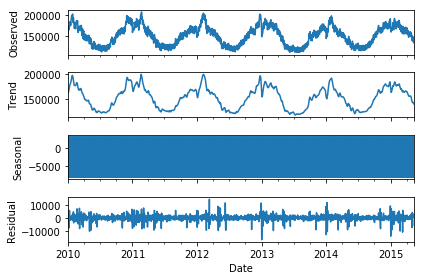

In [74]:
res = sm.tsa.seasonal_decompose(ts_en['EnergyConsump'].dropna(axis=0))
resplot = res.plot()

In energy consumption TS is no seasonality.

<h1 align="center">2. ARIMA Momdel for wage dataset (40%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

**I. Select ARIMA parameters your self ** 
Also you can follow the next scheme:
<img src='./pic/ARMA Scheme.png'>


Notes: you need follow to the steps
 * 0) Use data before 01.02.2015 
 * 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
 * 2) Dispersion is stabilized through transformation if needed.
 * 3) If the time series is non-stationary the differentiation degrees is
hosen.
 * 4) ACF/PACF are analyzed in order to understand whether AR(p)/MA(q) and seasonal $AR(P)/MA(Q)$  may be used.
 * 5) Candidate models are trained, their AIC/AIC is compared, choose trhe best model.
 * 6) Unbiasedness, stationarity and non-autocorrelation of the residuals of the obtained model are tested; if the tests fail model modifcations are reviewed.
 * 7) Build forecasts and forecastis interval for period from 01.02.2015 to 01.01.2017
     Calculate loss MACAPE of your Forecast.
     Does the forecast look like appropriate?

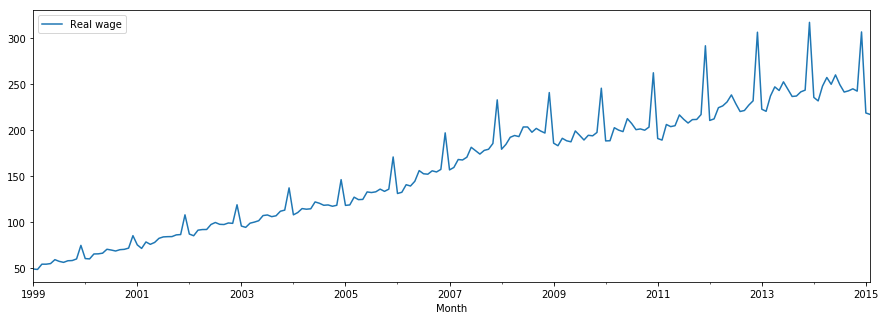

In [75]:
ts_mw = ts_mw.loc['1999.01.01':'2015.02.01']
ts_mw.plot(figsize = (15,5))

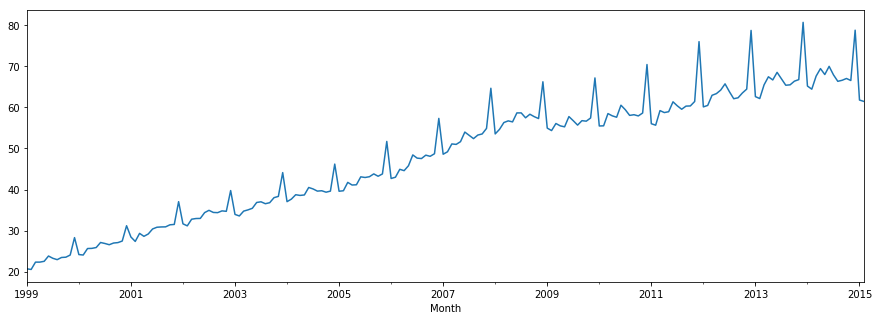

In [76]:
from copy import deepcopy
ts_mw_boxcox = deepcopy(ts_mw)
ts_mw_boxcox['wage_boxcox'] = stats.boxcox(ts_mw)[0]
ts_mw_boxcox['wage_boxcox'].plot(figsize=(15,5))

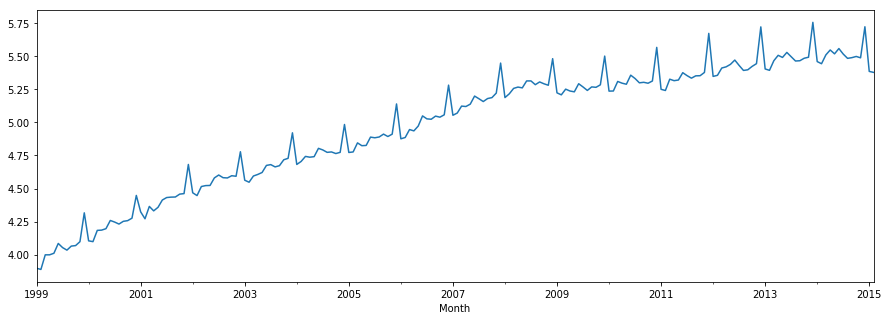

In [77]:
ts_mw_boxcox['wage_boxcox'] = np.log(ts_mw)
ts_mw_boxcox['wage_boxcox'].plot(figsize=(15,5))

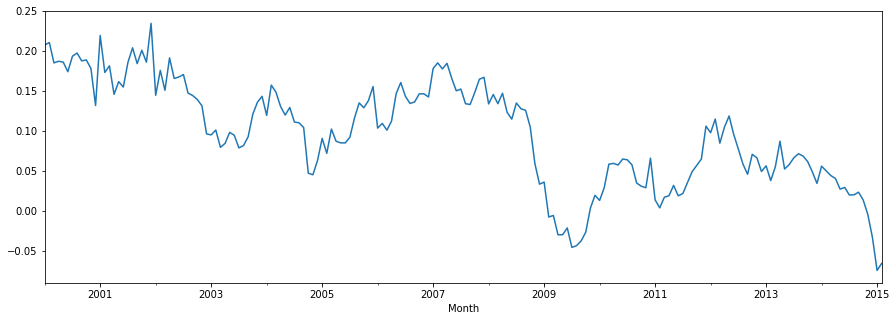

In [78]:
p = 12
sdiff_ts_mw_boxcox = (ts_mw_boxcox['wage_boxcox'] - ts_mw_boxcox['wage_boxcox'].shift(p))[p:]
sdiff_ts_mw_boxcox.plot(figsize=(15,5))

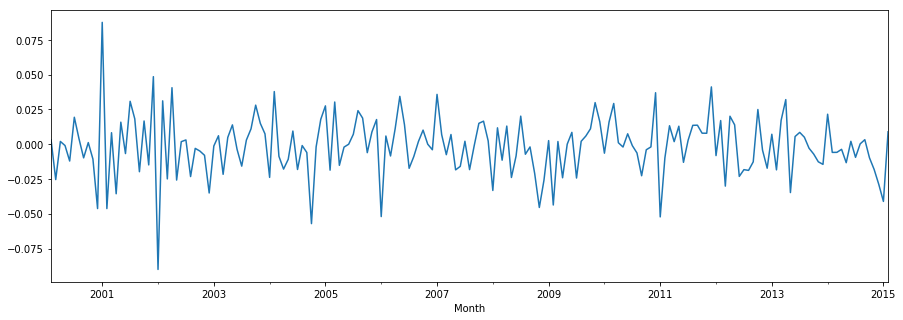

In [79]:
diff_sdiff_ts_mw_boxcox = (sdiff_ts_mw_boxcox  - sdiff_ts_mw_boxcox .shift(1))[1:]
diff_sdiff_ts_mw_boxcox.plot(figsize=(15,5))

We can see that there is no seasonality and trend, so we think that the TS is stationary. To make sure that the TS is stationary let's use KPSS.

In [80]:
from statsmodels.tsa import stattools
stat = stattools.kpss(np.array(diff_sdiff_ts_mw_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.069927, 
pvalue: 0.10 
maximal Lag: 14 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


Since pvalue is more than 0.1 we can't reject that the TS is stationary. So we assume that the TS is stationary.

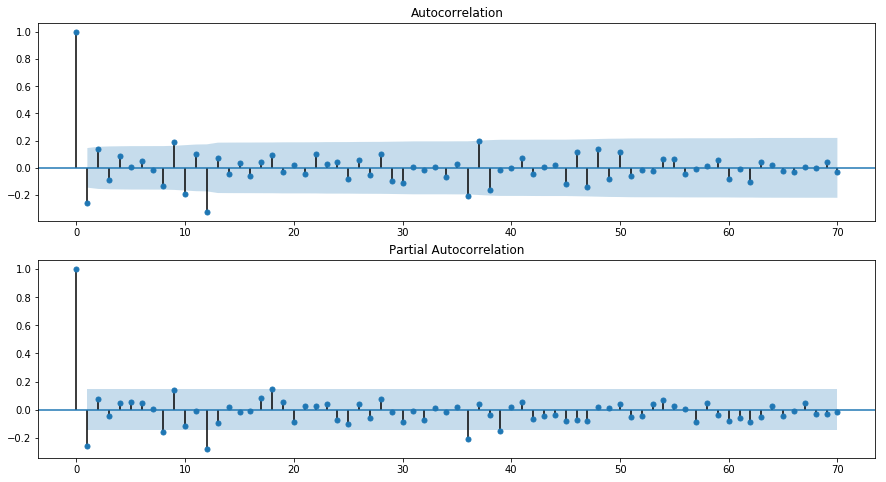

In [81]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_mw_boxcox.values.squeeze(), lags=70, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_mw_boxcox.values.squeeze(), lags=70, ax=ax2)

We see that we have for AR model p $\in \{1,8,9\}$ with seasonality s=12 and for MA model q $\in \{1,2,8,9\}$ with seasonality s=12. And we see that for AR model P $\in \{1,3\}$ and for MA model Q $\in \{1,3\}$. And since we differented for $p = 12$ one time and for $p=1$ one time, in SARIMA model we must put $d=1$ and $D=1$.

Now let us see for which params SARIMA model's aic is minimal.

In [82]:
%%time

p_s = [1,8,9]
q_s = [1,2,8,9]
P_s = [1,3]
Q_s = [1,3]
d=1
D=1
s=12
MODEL_min_aic = (1,1,1,1)
min_aic = np.inf
for p in p_s:
    for q in q_s:
        for Q in Q_s:
            for P in P_s:
                print 'model ' + str((p,q,P,Q)) + 'is running'
                try:
                    mod = sm.tsa.statespace.SARIMAX(ts_mw, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s))
                    results = mod.fit()
                except Exception:
                    continue
                if results.aic == np.NAN:
                    continue
                if results.aic < min_aic:
                    min_aic = results.aic
                    MODEL_min_aic = (p,q,P,Q)


model (1, 1, 1, 1)is running
model (1, 1, 3, 1)is running
model (1, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)


model (1, 1, 3, 3)is running
model (1, 2, 1, 1)is running
model (1, 2, 3, 1)is running
model (1, 2, 1, 3)is running
model (1, 2, 3, 3)is running
model (1, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 8, 1, 3)is running
model (1, 8, 3, 3)is running
model (1, 9, 1, 1)is running
model (1, 9, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 9, 1, 3)is running
model (1, 9, 3, 3)is running
model (8, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 1, 3)is running
model (8, 1, 3, 3)is running
model (8, 2, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 3, 1)is running
model (8, 2, 1, 3)is running
model (8, 2, 3, 3)is running
model (8, 8, 1, 1)is running
model (8, 8, 3, 1)is running
model (8, 8, 1, 3)is running
model (8, 8, 3, 3)is running
model (8, 9, 1, 1)is running
model (8, 9, 3, 1)is running
model (8, 9, 1, 3)is running
model (8, 9, 3, 3)is running
model (9, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 1, 3)is running
model (9, 1, 3, 3)is running
model (9, 2, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 1, 3)is running
model (9, 2, 3, 3)is running
model (9, 8, 1, 1)is running
model (9, 8, 3, 1)is running
model (9, 8, 1, 3)is running
model (9, 8, 3, 3)is running
model (9, 9, 1, 1)is running
model (9, 9, 3, 1)is running
model (9, 9, 1, 3)is running
model (9, 9, 3, 3)is running
CPU times: user 13min 46s, sys: 22min 47s, total: 36min 33s
Wall time: 10min 9s


In [83]:
MODEL_min_aic

(1, 1, 1, 1)

In [84]:
min_aic

990.67083947347191

So the best model is SARIMA(p=1,d=1,q=1, P=1, D=1, Q=1, S=12).

In [15]:
mod = sm.tsa.statespace.SARIMAX(ts_mw, trend='n', order=(1,1,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          Real wage   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -490.335
Date:                            Thu, 08 Jun 2017   AIC                            990.671
Time:                                    12:14:53   BIC                           1007.010
Sample:                                01-01-1999   HQIC                           997.287
                                     - 02-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4011      0.518     -0.775      0.438      -1.415       0.613
ma.L1          0.2602      0.522   

Let's now test residuals for unbiasedness, stationarity and non-autocorrelation.

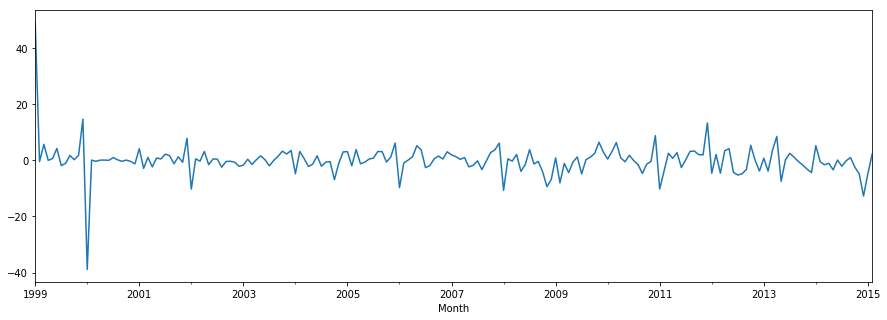

In [16]:
# plot residuals
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax)

In [17]:
# Normal test for unbiasedness
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=126.76708270690584, pvalue=2.9708296296216527e-28)

In [18]:
# kpss for stationarity
from statsmodels.tsa import stattools
stat = stattools.kpss(np.array(results.resid))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.240107, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


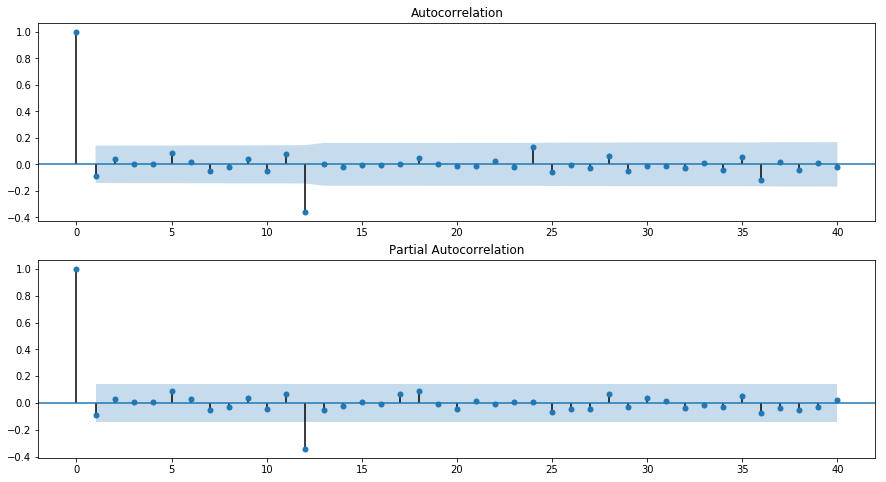

In [19]:
# ACF and PACF for residuals
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid.values.squeeze(), lags=40, ax=ax2)

Now let's do forecast for 2015.01.01-2017.01.01

In [68]:
forecast = results.predict('2015-01-01', '2017-01-01', dynamic = False)
forecast

2015-01-01    223.284864
2015-02-01    214.575322
2015-03-01    233.041897
2015-04-01    243.034502
2015-05-01    235.188844
2015-06-01    245.684032
2015-07-01    234.655942
2015-08-01    226.333828
2015-09-01    227.609045
2015-10-01    229.903328
2015-11-01    227.193717
2015-12-01    293.691444
2016-01-01    202.343707
2016-02-01    200.689781
2016-03-01    217.300420
2016-04-01    227.753662
2016-05-01    219.515557
2016-06-01    230.284434
2016-07-01    218.837294
2016-08-01    210.190104
2016-09-01    211.441934
2016-10-01    213.829826
2016-11-01    210.911104
2016-12-01    279.703382
2017-01-01    184.912578
Freq: MS, dtype: float64

Now let's count the loss of forecast and compare the real values of TS with forecast.

In [26]:
def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [74]:
ts = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_real = ts.loc['2015.01.01':'2017.01.01']

ts_forecast = pd.DataFrame(index = ts_real.index)
ts_forecast['forecast wage'] = np.array(forecast)

qualityMACAPE(ts_real['Real wage'],ts_forecast['forecast wage'])[0]

0.045528121918497942

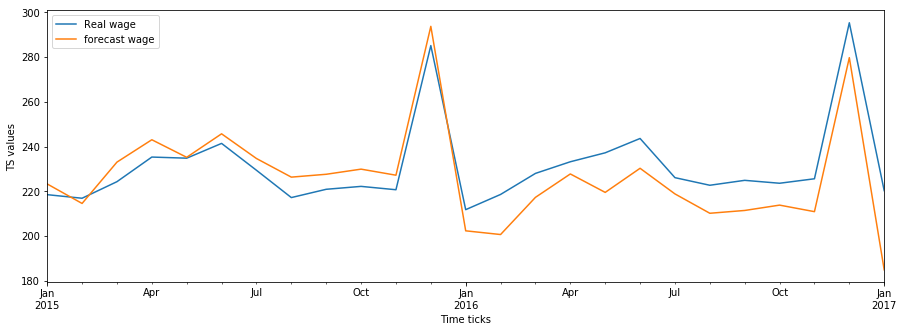

In [75]:
ts_real.merge(ts_forecast, right_index=True, left_index=True).plot(figsize = (15,5))

plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.show()

**II. Find the best parameters of ARIMA automaticaly** 
* 0) Use data before 01.02.2015 
* 1) Plot the graph of time series, preprocess data (delete tail, make calendar transformation if needed)
* 2) Run grid search for ARIMA parameters (at least for 3 distinct values for $p,q,d, P, Q, D$). 
How many time does it take?
* 4) Find the best set of parameters according to AIC.
* 5) Build the forecast of the best model and it's forecasting interval for period from 01.02.2015 to 01.01.2017.
* 6) Calculate locc MACAPE of your forecast.

Let's run grid search for Arima params.

In [92]:
%% time

p_s = [1,8,9]
q_s = [1,2,8,9]
P_s = [1,3]
Q_s = [1,3]
d_s = [1,2,3]
D_s = [1,2,3]
s=12
MODEL_min_aic = (1,1,1,1,1,1)
min_aic = 10000
for p in p_s:
    for q in q_s:
        for Q in Q_s:
            for P in P_s:
                for d in d_s:
                    for D in D_s:
                        print 'model ' + str((p,d,q,P,D,Q)) + 'is running'
                        try:
                            mod = sm.tsa.statespace.SARIMAX(ts_mw, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s))
                            results = mod.fit()
                        except Exception:
                            continue
                        if results.aic == np.NAN:
                            continue
                        if results.aic < min_aic:
                            min_aic = results.aic
                            MODEL_min_aic = (p,d,q,P,D,Q)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
model (1, 1, 1, 1, 1, 1)is running
model (1, 1, 1, 1, 2, 1)is running
model (1, 1, 1, 1, 3, 1)is running
model (1, 2, 1, 1, 1, 1)is running
model (1, 2, 1, 1, 2, 1)is running
model (1, 2, 1, 1, 3, 1)is running
model (1, 3, 1, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 3, 1, 1, 2, 1)is running
model (1, 3, 1, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 1, 3, 1, 1)is running
model (1, 1, 1, 3, 2, 1)is running
model (1, 1, 1, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 1, 3, 1, 1)is running
model (1, 2, 1, 3, 2, 1)is running
model (1, 2, 1, 3, 3, 1)is running
model (1, 3, 1, 3, 1, 1)is running
model (1, 3, 1, 3, 2, 1)is running
model (1, 3, 1, 3, 3, 1)is running
model (1, 1, 1, 1, 1, 3)is running
model (1, 1, 1, 1, 2, 3)is running
model (1, 1, 1, 1, 3, 3)is running
model (1, 2, 1, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 1, 1, 2, 3)is running
model (1, 2, 1, 1, 3, 3)is running
model (1, 3, 1, 1, 1, 3)is running
model (1, 3, 1, 1, 2, 3)is running
model (1, 3, 1, 1, 3, 3)is running
model (1, 1, 1, 3, 1, 3)is running
model (1, 1, 1, 3, 2, 3)is running
model (1, 1, 1, 3, 3, 3)is running
model (1, 2, 1, 3, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 1, 3, 2, 3)is running
model (1, 2, 1, 3, 3, 3)is running
model (1, 3, 1, 3, 1, 3)is running
model (1, 3, 1, 3, 2, 3)is running
model (1, 3, 1, 3, 3, 3)is running
model (1, 1, 2, 1, 1, 1)is running
model (1, 1, 2, 1, 2, 1)is running
model (1, 1, 2, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 1, 1, 1)is running
model (1, 2, 2, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 1, 3, 1)is running
model (1, 3, 2, 1, 1, 1)is running
model (1, 3, 2, 1, 2, 1)is running
model (1, 3, 2, 1, 3, 1)is running
model (1, 1, 2, 3, 1, 1)is running
model (1, 1, 2, 3, 2, 1)is running
model (1, 1, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 3, 2, 3, 1, 1)is running
model (1, 3, 2, 3, 2, 1)is running
model (1, 3, 2, 3, 3, 1)is running
model (1, 1, 2, 1, 1, 3)is running
model (1, 1, 2, 1, 2, 3)is running
model (1, 1, 2, 1, 3, 3)is running
model (1, 2, 2, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 1, 2, 3)is running
model (1, 2, 2, 1, 3, 3)is running
model (1, 3, 2, 1, 1, 3)is running
model (1, 3, 2, 1, 2, 3)is running
model (1, 3, 2, 1, 3, 3)is running
model (1, 1, 2, 3, 1, 3)is running
model (1, 1, 2, 3, 2, 3)is running
model (1, 1, 2, 3, 3, 3)is running
model (1, 2, 2, 3, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 2, 3, 2, 3)is running
model (1, 2, 2, 3, 3, 3)is running
model (1, 3, 2, 3, 1, 3)is running
model (1, 3, 2, 3, 2, 3)is running
model (1, 3, 2, 3, 3, 3)is running
model (1, 1, 8, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 8, 1, 2, 1)is running
model (1, 1, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 8, 1, 1, 1)is running
model (1, 2, 8, 1, 2, 1)is running
model (1, 2, 8, 1, 3, 1)is running
model (1, 3, 8, 1, 1, 1)is running
model (1, 3, 8, 1, 2, 1)is running
model (1, 3, 8, 1, 3, 1)is running
model (1, 1, 8, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 8, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 8, 3, 1, 1)is running
model (1, 2, 8, 3, 2, 1)is running
model (1, 2, 8, 3, 3, 1)is running
model (1, 3, 8, 3, 1, 1)is running
model (1, 3, 8, 3, 2, 1)is running
model (1, 3, 8, 3, 3, 1)is running
model (1, 1, 8, 1, 1, 3)is running
model (1, 1, 8, 1, 2, 3)is running
model (1, 1, 8, 1, 3, 3)is running
model (1, 2, 8, 1, 1, 3)is running
model (1, 2, 8, 1, 2, 3)is running
model (1, 2, 8, 1, 3, 3)is running
model (1, 3, 8, 1, 1, 3)is running
model (1, 3, 8, 1, 2, 3)is running
model (1, 3, 8, 1, 3, 3)is running
model (1, 1, 8, 3, 1, 3)is running
model (1, 1, 8, 3, 2, 3)is running
model (1, 1, 8, 3, 3, 3)is running
model (1, 2, 8, 3, 1, 3)is running
model (1, 2, 8, 3, 2, 3)is running
model (1, 2, 8, 3, 3, 3)is running
model (1, 3, 8, 3, 1, 3)is running
model (1, 3, 8, 3, 2, 3)is running
model (1, 3, 8, 3, 3, 3)is running
model (1, 1, 9, 1, 1, 1)is running
model (1, 1, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 3, 9, 1, 1, 1)is running
model (1, 3, 9, 1, 2, 1)is running
model (1, 3, 9, 1, 3, 1)is running
model (1, 1, 9, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 1, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 3, 9, 3, 1, 1)is running
model (1, 3, 9, 3, 2, 1)is running
model (1, 3, 9, 3, 3, 1)is running
model (1, 1, 9, 1, 1, 3)is running
model (1, 1, 9, 1, 2, 3)is running
model (1, 1, 9, 1, 3, 3)is running
model (1, 2, 9, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 1, 2, 3)is running
model (1, 2, 9, 1, 3, 3)is running
model (1, 3, 9, 1, 1, 3)is running
model (1, 3, 9, 1, 2, 3)is running
model (1, 3, 9, 1, 3, 3)is running
model (1, 1, 9, 3, 1, 3)is running
model (1, 1, 9, 3, 2, 3)is running
model (1, 1, 9, 3, 3, 3)is running
model (1, 2, 9, 3, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (1, 2, 9, 3, 2, 3)is running
model (1, 2, 9, 3, 3, 3)is running
model (1, 3, 9, 3, 1, 3)is running
model (1, 3, 9, 3, 2, 3)is running
model (1, 3, 9, 3, 3, 3)is running
model (8, 1, 1, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 1, 1, 2, 1)is running
model (8, 1, 1, 1, 3, 1)is running
model (8, 2, 1, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 1, 1, 2, 1)is running
model (8, 2, 1, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 1, 1, 1, 1)is running
model (8, 3, 1, 1, 2, 1)is running
model (8, 3, 1, 1, 3, 1)is running
model (8, 1, 1, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 1, 3, 2, 1)is running
model (8, 1, 1, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 1, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 1, 3, 2, 1)is running
model (8, 2, 1, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 1, 3, 1, 1)is running
model (8, 3, 1, 3, 2, 1)is running
model (8, 3, 1, 3, 3, 1)is running
model (8, 1, 1, 1, 1, 3)is running
model (8, 1, 1, 1, 2, 3)is running
model (8, 1, 1, 1, 3, 3)is running
model (8, 2, 1, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 1, 1, 2, 3)is running
model (8, 2, 1, 1, 3, 3)is running
model (8, 3, 1, 1, 1, 3)is running
model (8, 3, 1, 1, 2, 3)is running
model (8, 3, 1, 1, 3, 3)is running
model (8, 1, 1, 3, 1, 3)is running
model (8, 1, 1, 3, 2, 3)is running
model (8, 1, 1, 3, 3, 3)is running
model (8, 2, 1, 3, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 1, 3, 2, 3)is running
model (8, 2, 1, 3, 3, 3)is running
model (8, 3, 1, 3, 1, 3)is running
model (8, 3, 1, 3, 2, 3)is running
model (8, 3, 1, 3, 3, 3)is running
model (8, 1, 2, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 2, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 2, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 1, 3, 1)is running
model (8, 3, 2, 1, 1, 1)is running
model (8, 3, 2, 1, 2, 1)is running
model (8, 3, 2, 1, 3, 1)is running
model (8, 1, 2, 3, 1, 1)is running
model (8, 1, 2, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 3, 2, 1)is running
model (8, 2, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 2, 3, 1, 1)is running
model (8, 3, 2, 3, 2, 1)is running
model (8, 3, 2, 3, 3, 1)is running
model (8, 1, 2, 1, 1, 3)is running
model (8, 1, 2, 1, 2, 3)is running
model (8, 1, 2, 1, 3, 3)is running
model (8, 2, 2, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 2, 1, 2, 3)is running
model (8, 2, 2, 1, 3, 3)is running
model (8, 3, 2, 1, 1, 3)is running
model (8, 3, 2, 1, 2, 3)is running
model (8, 3, 2, 1, 3, 3)is running
model (8, 1, 2, 3, 1, 3)is running
model (8, 1, 2, 3, 2, 3)is running
model (8, 1, 2, 3, 3, 3)is running
model (8, 2, 2, 3, 1, 3)is running
model (8, 2, 2, 3, 2, 3)is running
model (8, 2, 2, 3, 3, 3)is running
model (8, 3, 2, 3, 1, 3)is running
model (8, 3, 2, 3, 2, 3)is running
model (8, 3, 2, 3, 3, 3)is running
model (8, 1, 8, 1, 1, 1)is running
model (8, 1, 8, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 8, 1, 1, 1)is running
model (8, 2, 8, 1, 2, 1)is running
model (8, 2, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 8, 1, 1, 1)is running
model (8, 3, 8, 1, 2, 1)is running
model (8, 3, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 8, 3, 1, 1)is running
model (8, 1, 8, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 8, 3, 1, 1)is running
model (8, 2, 8, 3, 2, 1)is running
model (8, 2, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 8, 3, 1, 1)is running
model (8, 3, 8, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 8, 1, 1, 3)is running
model (8, 1, 8, 1, 2, 3)is running
model (8, 1, 8, 1, 3, 3)is running
model (8, 2, 8, 1, 1, 3)is running
model (8, 2, 8, 1, 2, 3)is running
model (8, 2, 8, 1, 3, 3)is running
model (8, 3, 8, 1, 1, 3)is running
model (8, 3, 8, 1, 2, 3)is running
model (8, 3, 8, 1, 3, 3)is running
model (8, 1, 8, 3, 1, 3)is running
model (8, 1, 8, 3, 2, 3)is running
model (8, 1, 8, 3, 3, 3)is running
model (8, 2, 8, 3, 1, 3)is running
model (8, 2, 8, 3, 2, 3)is running
model (8, 2, 8, 3, 3, 3)is running
model (8, 3, 8, 3, 1, 3)is running
model (8, 3, 8, 3, 2, 3)is running
model (8, 3, 8, 3, 3, 3)is running
model (8, 1, 9, 1, 1, 1)is running
model (8, 1, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 9, 1, 1, 1)is running
model (8, 2, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 9, 1, 1, 1)is running
model (8, 3, 9, 1, 2, 1)is running
model (8, 3, 9, 1, 3, 1)is running
model (8, 1, 9, 3, 1, 1)is running
model (8, 1, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 1, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 9, 3, 1, 1)is running
model (8, 2, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 2, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (8, 3, 9, 3, 1, 1)is running
model (8, 3, 9, 3, 2, 1)is running
model (8, 3, 9, 3, 3, 1)is running
model (8, 1, 9, 1, 1, 3)is running
model (8, 1, 9, 1, 2, 3)is running
model (8, 1, 9, 1, 3, 3)is running
model (8, 2, 9, 1, 1, 3)is running
model (8, 2, 9, 1, 2, 3)is running
model (8, 2, 9, 1, 3, 3)is running
model (8, 3, 9, 1, 1, 3)is running
model (8, 3, 9, 1, 2, 3)is running
model (8, 3, 9, 1, 3, 3)is running
model (8, 1, 9, 3, 1, 3)is running
model (8, 1, 9, 3, 2, 3)is running
model (8, 1, 9, 3, 3, 3)is running
model (8, 2, 9, 3, 1, 3)is running
model (8, 2, 9, 3, 2, 3)is running
model (8, 2, 9, 3, 3, 3)is running
model (8, 3, 9, 3, 1, 3)is running
model (8, 3, 9, 3, 2, 3)is running
model (8, 3, 9, 3, 3, 3)is running
model (9, 1, 1, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 1, 1, 2, 1)is running
model (9, 1, 1, 1, 3, 1)is running
model (9, 2, 1, 1, 1, 1)is running
model (9, 2, 1, 1, 2, 1)is running
model (9, 2, 1, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 1, 1, 1, 1)is running
model (9, 3, 1, 1, 2, 1)is running
model (9, 3, 1, 1, 3, 1)is running
model (9, 1, 1, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 1, 3, 2, 1)is running
model (9, 1, 1, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 1, 3, 1, 1)is running
model (9, 2, 1, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 1, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 1, 3, 1, 1)is running
model (9, 3, 1, 3, 2, 1)is running
model (9, 3, 1, 3, 3, 1)is running
model (9, 1, 1, 1, 1, 3)is running
model (9, 1, 1, 1, 2, 3)is running
model (9, 1, 1, 1, 3, 3)is running
model (9, 2, 1, 1, 1, 3)is running
model (9, 2, 1, 1, 2, 3)is running
model (9, 2, 1, 1, 3, 3)is running
model (9, 3, 1, 1, 1, 3)is running
model (9, 3, 1, 1, 2, 3)is running
model (9, 3, 1, 1, 3, 3)is running
model (9, 1, 1, 3, 1, 3)is running
model (9, 1, 1, 3, 2, 3)is running
model (9, 1, 1, 3, 3, 3)is running
model (9, 2, 1, 3, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 1, 3, 2, 3)is running
model (9, 2, 1, 3, 3, 3)is running
model (9, 3, 1, 3, 1, 3)is running
model (9, 3, 1, 3, 2, 3)is running
model (9, 3, 1, 3, 3, 3)is running
model (9, 1, 2, 1, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 2, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 2, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 1, 1, 1)is running
model (9, 2, 2, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 2, 1, 1, 1)is running
model (9, 3, 2, 1, 2, 1)is running
model (9, 3, 2, 1, 3, 1)is running
model (9, 1, 2, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 2, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 3, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 2, 3, 1, 1)is running
model (9, 3, 2, 3, 2, 1)is running
model (9, 3, 2, 3, 3, 1)is running
model (9, 1, 2, 1, 1, 3)is running
model (9, 1, 2, 1, 2, 3)is running
model (9, 1, 2, 1, 3, 3)is running
model (9, 2, 2, 1, 1, 3)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 2, 1, 2, 3)is running
model (9, 2, 2, 1, 3, 3)is running
model (9, 3, 2, 1, 1, 3)is running
model (9, 3, 2, 1, 2, 3)is running
model (9, 3, 2, 1, 3, 3)is running
model (9, 1, 2, 3, 1, 3)is running
model (9, 1, 2, 3, 2, 3)is running
model (9, 1, 2, 3, 3, 3)is running
model (9, 2, 2, 3, 1, 3)is running
model (9, 2, 2, 3, 2, 3)is running
model (9, 2, 2, 3, 3, 3)is running
model (9, 3, 2, 3, 1, 3)is running
model (9, 3, 2, 3, 2, 3)is running
model (9, 3, 2, 3, 3, 3)is running
model (9, 1, 8, 1, 1, 1)is running
model (9, 1, 8, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 8, 1, 1, 1)is running
model (9, 2, 8, 1, 2, 1)is running
model (9, 2, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 8, 1, 1, 1)is running
model (9, 3, 8, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 8, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 8, 3, 1, 1)is running
model (9, 1, 8, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 8, 3, 1, 1)is running
model (9, 2, 8, 3, 2, 1)is running
model (9, 2, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 8, 3, 1, 1)is running
model (9, 3, 8, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 8, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 8, 1, 1, 3)is running
model (9, 1, 8, 1, 2, 3)is running
model (9, 1, 8, 1, 3, 3)is running
model (9, 2, 8, 1, 1, 3)is running
model (9, 2, 8, 1, 2, 3)is running
model (9, 2, 8, 1, 3, 3)is running
model (9, 3, 8, 1, 1, 3)is running
model (9, 3, 8, 1, 2, 3)is running
model (9, 3, 8, 1, 3, 3)is running
model (9, 1, 8, 3, 1, 3)is running
model (9, 1, 8, 3, 2, 3)is running
model (9, 1, 8, 3, 3, 3)is running
model (9, 2, 8, 3, 1, 3)is running
model (9, 2, 8, 3, 2, 3)is running
model (9, 2, 8, 3, 3, 3)is running
model (9, 3, 8, 3, 1, 3)is running
model (9, 3, 8, 3, 2, 3)is running
model (9, 3, 8, 3, 3, 3)is running
model (9, 1, 9, 1, 1, 1)is running
model (9, 1, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 9, 1, 1, 1)is running
model (9, 2, 9, 1, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 9, 1, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 9, 1, 1, 1)is running
model (9, 3, 9, 1, 2, 1)is running
model (9, 3, 9, 1, 3, 1)is running
model (9, 1, 9, 3, 1, 1)is running
model (9, 1, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 1, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 9, 3, 1, 1)is running
model (9, 2, 9, 3, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 2, 9, 3, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (9, 3, 9, 3, 1, 1)is running
model (9, 3, 9, 3, 2, 1)is running
model (9, 3, 9, 3, 3, 1)is running
model (9, 1, 9, 1, 1, 3)is running
model (9, 1, 9, 1, 2, 3)is running
model (9, 1, 9, 1, 3, 3)is running
model (9, 2, 9, 1, 1, 3)is running
model (9, 2, 9, 1, 2, 3)is running
model (9, 2, 9, 1, 3, 3)is running
model (9, 3, 9, 1, 1, 3)is running
model (9, 3, 9, 1, 2, 3)is running
model (9, 3, 9, 1, 3, 3)is running
model (9, 1, 9, 3, 1, 3)is running
model (9, 1, 9, 3, 2, 3)is running
model (9, 1, 9, 3, 3, 3)is running
model (9, 2, 9, 3, 1, 3)is running
model (9, 2, 9, 3, 2, 3)is running
model (9, 2, 9, 3, 3, 3)is running
model (9, 3, 9, 3, 1, 3)is running
model (9, 3, 9, 3, 2, 3)is running
model (9, 3, 9, 3, 3, 3)is running
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


In [93]:
MODEL_min_aic

(1, 1, 1, 3, 2, 1)

In [94]:
min_aic

930.18614699161287

So the best model is SARIMA(p=1, d=1, q=1, P=3, D=2, Q=1).

In [95]:
mod = sm.tsa.statespace.SARIMAX(ts_mw, trend='n', order=(1,1,1), seasonal_order=(3,2,1,12))
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          Real wage   No. Observations:                  194
Model:             SARIMAX(1, 1, 1)x(3, 2, 1, 12)   Log Likelihood                -458.093
Date:                            Wed, 07 Jun 2017   AIC                            930.186
Time:                                    17:06:28   BIC                            953.061
Sample:                                01-01-1999   HQIC                           939.449
                                     - 02-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7149     92.344     -0.008      0.994    -181.706     180.276
ma.L1          0.7146     92.367   

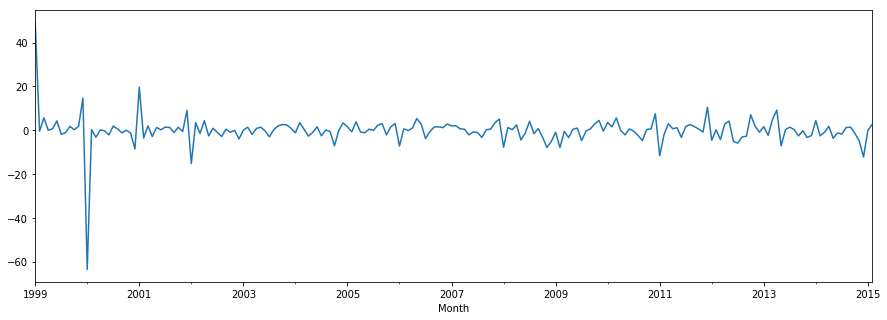

In [96]:
# plot residuals
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax)

In [97]:
# Normal test for unbiasedness
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=152.24846956531769, pvalue=8.702918064524326e-34)

In [98]:
# kpss for stationarity
from statsmodels.tsa import stattools
stat = stattools.kpss(np.array(results.resid))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.097484, 
pvalue: 0.10 
maximal Lag: 15 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


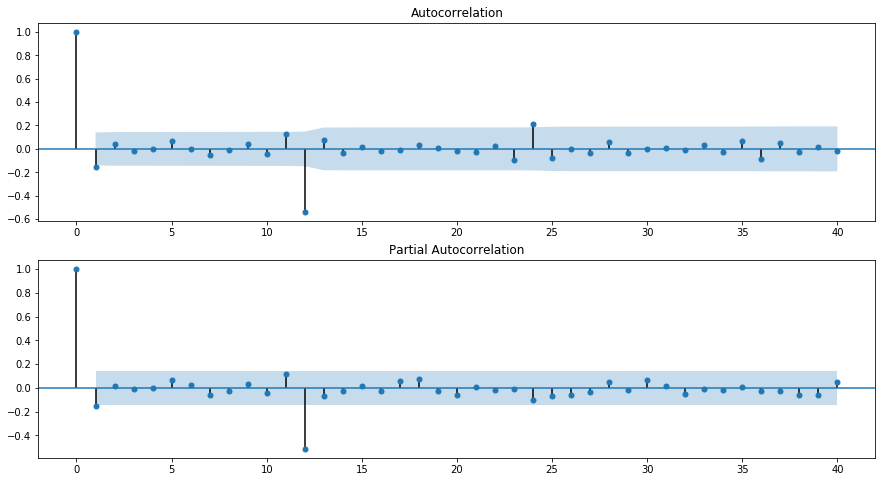

In [99]:
# ACF and PACF for residuals
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid.values.squeeze(), lags=40, ax=ax2)

Now let us do forecast, count the loss by MACAPE and compare forecast with real values.

In [100]:
forecast = results.predict('2015-01-01', '2017-01-01', dynamic = False)
forecast

2015-01-01    218.600004
2015-02-01    214.213552
2015-03-01    235.646131
2015-04-01    243.086066
2015-05-01    236.225777
2015-06-01    248.080918
2015-07-01    238.403807
2015-08-01    231.164972
2015-09-01    233.380493
2015-10-01    234.681396
2015-11-01    234.043277
2015-12-01    308.771533
2016-01-01    213.133599
2016-02-01    212.665099
2016-03-01    230.552068
2016-04-01    236.798126
2016-05-01    232.884202
2016-06-01    244.006469
2016-07-01    232.619069
2016-08-01    224.006776
2016-09-01    226.012158
2016-10-01    228.963221
2016-11-01    229.570788
2016-12-01    311.084535
2017-01-01    208.053556
Freq: MS, dtype: float64

In [101]:
ts = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_real = ts.loc['2015.01.01':'2017.01.01']

ts_forecast = pd.DataFrame(index = ts_real.index)
ts_forecast['forecast wage'] = np.array(forecast)

qualityMACAPE(ts_real['Real wage'],ts_forecast['forecast wage'])[0]

0.02987208562546078

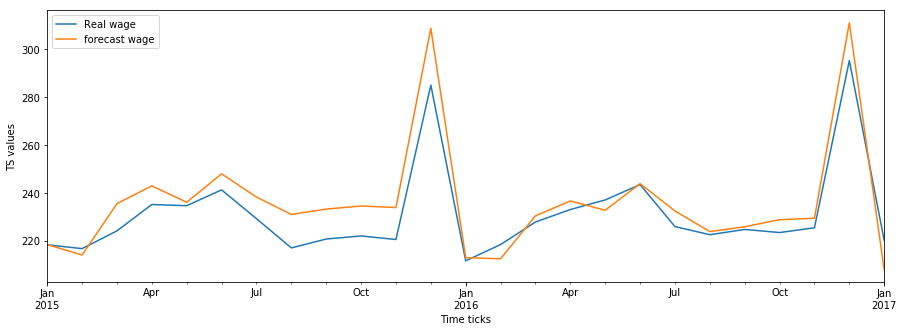

In [102]:
ts_real.merge(ts_forecast, right_index=True, left_index=True).plot(figsize = (15,5))

plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.show()

<h1 align="center">3. ARIMA Model for wage dataset (55%) </h1>
You need to analyseTS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">energy_consumption.csv</span> in accordance with forecasting scheme (see lecture slide Scheme of TS forecasting with ARIMA) and then build forecast.

In [7]:
ts_en_cons = ts_en['EnergyConsump']
ts_en_cons = ts_en_cons.loc[:'2015.01.01']

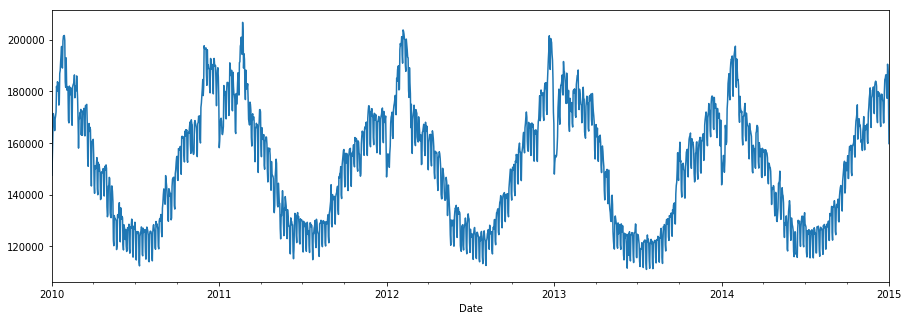

In [8]:
ts_en_cons.plot(figsize = (15,5))

**I. Select ARIMA parameters yourself **
Follow to the steps from 2.I. 

**II. Find the best parameters of ARIMA automaticaly**

** III. Adding of exogenious variables**

* 1) Try to add in models from 3.I. and 3.II exogenious variables (at least one of Temp1, Temp2, Saturday and Sunday).
* 2) Does it make accuracy of foreacast for period from 01.02.2015 to 01.01.2017 better?

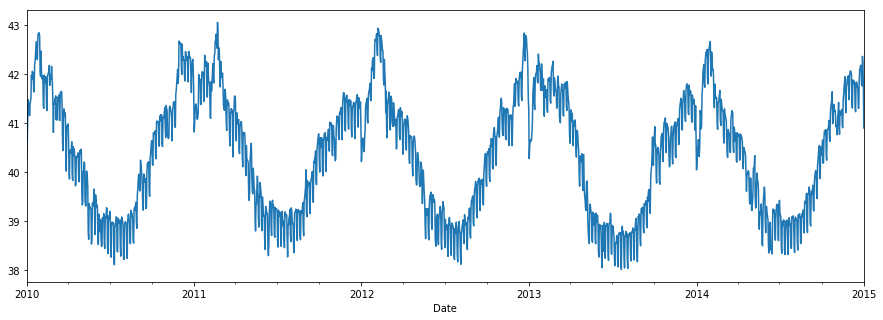

In [10]:
# from copy import deepcopy
ts_en_boxcox = deepcopy(pd.DataFrame(ts_en_cons))
ts_en_boxcox['en_cons_boxcox'] = stats.boxcox(ts_en_cons)[0]
ts_en_boxcox['en_cons_boxcox'].plot(figsize=(15,5))

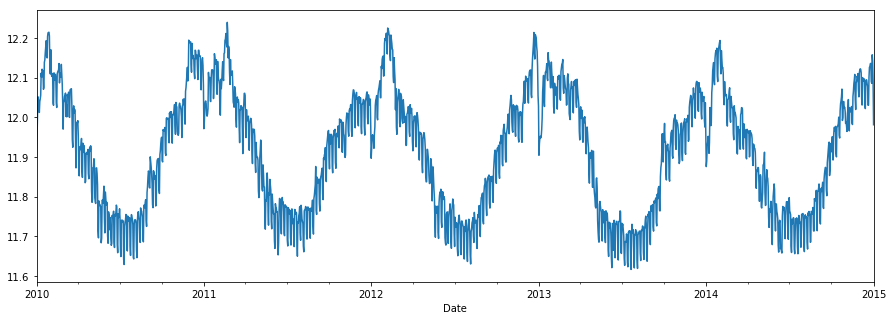

In [11]:
ts_en_boxcox['en_cons_boxcox'] = np.log(ts_en_boxcox)
ts_en_boxcox['en_cons_boxcox'].plot(figsize=(15,5))

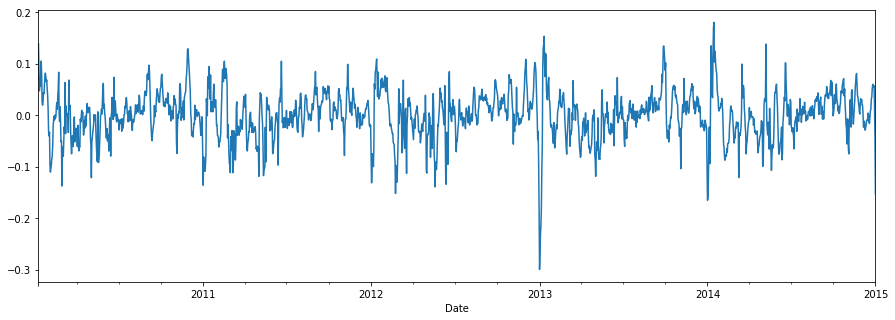

In [12]:
p = 7
sdiff_ts_en_cons_boxcox = (ts_en_boxcox['en_cons_boxcox'] - ts_en_boxcox['en_cons_boxcox'].shift(p))[p:]
sdiff_ts_en_cons_boxcox.plot(figsize=(15,5))

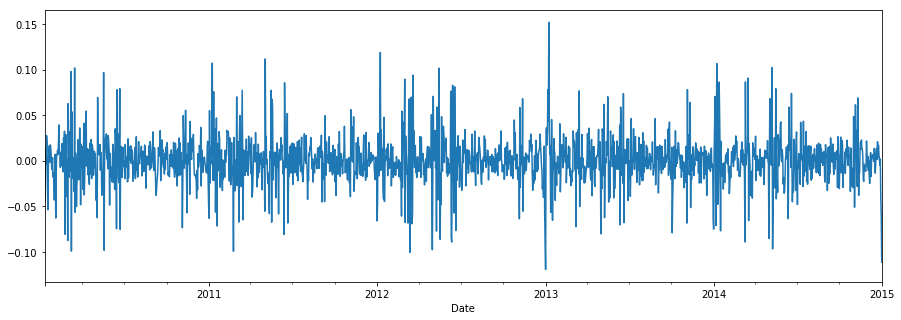

In [13]:
diff_sdiff_ts_en_cons_boxcox = (sdiff_ts_en_cons_boxcox  - sdiff_ts_en_cons_boxcox .shift(1))[1:]
diff_sdiff_ts_en_cons_boxcox.plot(figsize=(15,5))

We think that this TS is stationary, because there is no trend, no sasonality.

In [16]:
stat = stattools.kpss(np.array(diff_sdiff_ts_en_cons_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.032283, 
pvalue: 0.10 
maximal Lag: 25 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Kpss test is not rejecting the stationarity of TS.

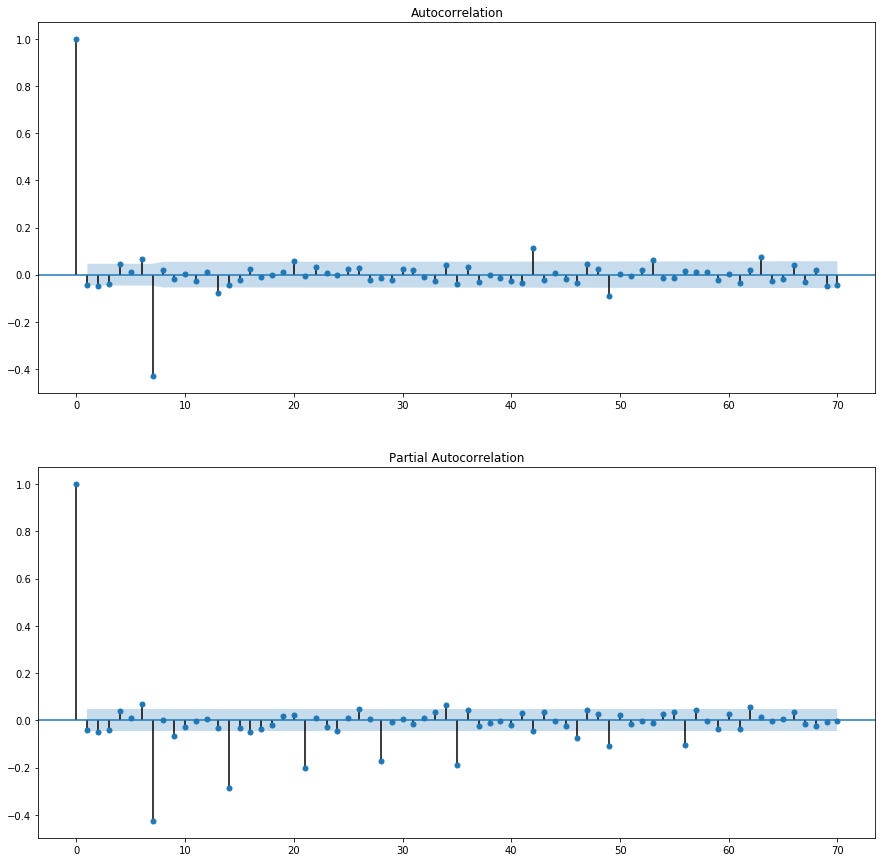

In [17]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_en_cons_boxcox.values.squeeze(), lags=70, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_en_cons_boxcox.values.squeeze(), lags=70, ax=ax2)

So for SARIMA model we can put $p\in \{2,6\}, q\in \{1,2,6\}, P = 8, Q \in \{1,6,7\} $ and $s=7$.

In [19]:
%%time

mod = sm.tsa.statespace.SARIMAX(ts_en_cons, trend='n', order=(2,1,6), seasonal_order=(8,1,1,7))
results = mod.fit()
print results.summary()

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1827
Model:             SARIMAX(2, 1, 6)x(8, 1, 1, 7)   Log Likelihood              -17398.631
Date:                           Fri, 09 Jun 2017   AIC                          34833.261
Time:                                   13:44:03   BIC                          34932.449
Sample:                               01-01-2010   HQIC                         34869.848
                                    - 01-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2799      0.297     -0.942      0.346      -0.862       0.303
ar.L2          0.6342      0.297      2.134

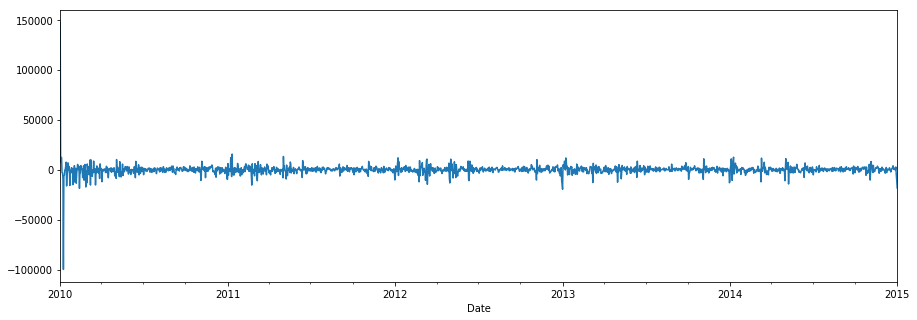

In [20]:
# plot residuals
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax)

In [21]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=2684.0759789479944, pvalue=0.0)

In [22]:
# kpss for stationarity
stat = stattools.kpss(np.array(results.resid))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.319688, 
pvalue: 0.10 
maximal Lag: 25 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


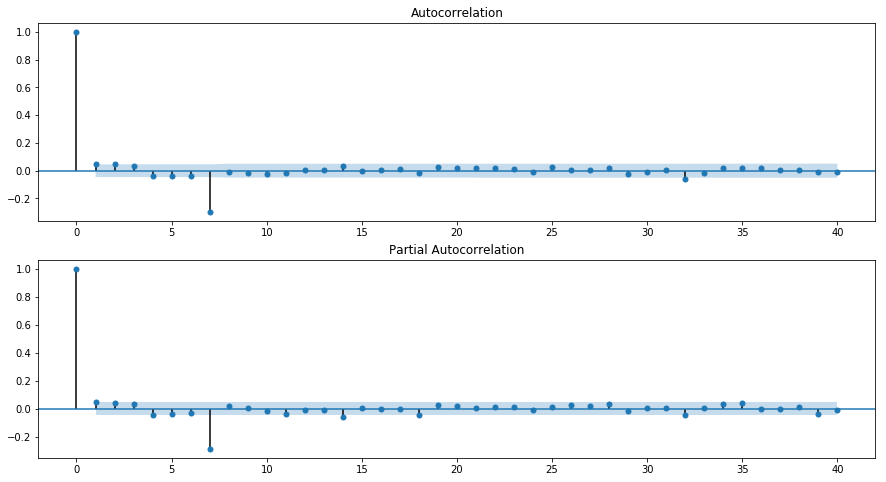

In [23]:
# ACF and PACF for residuals
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid.values.squeeze(), lags=40, ax=ax2)

Now let's do forecast, count MACAPE and compare with real values.

In [24]:
forecast = results.predict('2015-01-01', '2015-05-27', dynamic = False)
forecast

2015-01-01    178169.744128
2015-01-02    160300.650789
2015-01-03    152406.577368
2015-01-04    151505.620344
2015-01-05    161896.035601
2015-01-06    160297.889061
2015-01-07    155614.705912
2015-01-08    148554.166323
2015-01-09    148476.244835
2015-01-10    140253.286024
2015-01-11    138568.009762
2015-01-12    148525.114564
2015-01-13    148328.312283
2015-01-14    147552.342660
2015-01-15    145918.155307
2015-01-16    146161.835494
2015-01-17    137307.841573
2015-01-18    135677.812551
2015-01-19    145452.935900
2015-01-20    145749.835640
2015-01-21    145622.032388
2015-01-22    145298.583582
2015-01-23    145379.633720
2015-01-24    136665.690083
2015-01-25    134947.822183
2015-01-26    144880.976253
2015-01-27    145432.697483
2015-01-28    145899.253944
2015-01-29    146237.240925
2015-01-30    146345.538899
                  ...      
2015-04-28    142124.709508
2015-04-29    141880.909737
2015-04-30    141250.512984
2015-05-01    141397.952165
2015-05-02    132743

In [27]:
#ts = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_en_real = ts_en.loc['2015.01.01':'2015-05-27']

ts_en_forecast = pd.DataFrame(index = ts_en_real.index)
ts_en_forecast['forecast cons'] = np.array(forecast)

qualityMACAPE(ts_en_real['EnergyConsump'],ts_en_forecast['forecast cons'])[0]

0.14971677363763411

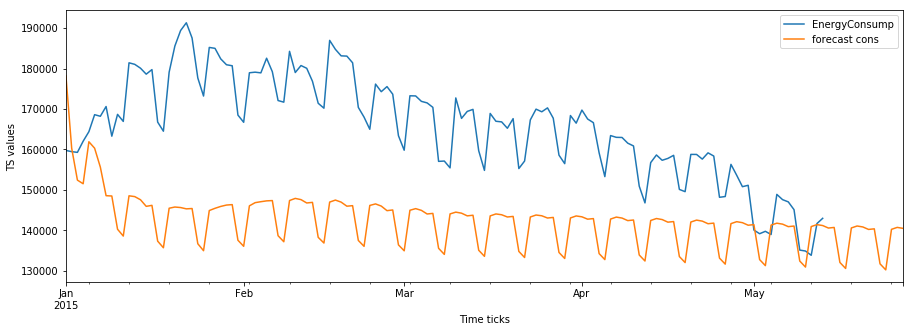

In [28]:
pd.DataFrame(ts_en_real['EnergyConsump']).merge(pd.DataFrame(ts_en_forecast['forecast cons']), right_index=True, left_index=True).plot(figsize = (15,5))

plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.show()

Now let's find SARIMA optimal params by grid search.

In [55]:
%%time

p_s = [2,6]
q_s = [1,2]
P_s = [4,6,8]
Q_s = [1,6]
d_s = [1,2]
D_s = [1,2,3]
s=7
MODEL_min_aic = (1,1,1,1,1,1)
min_aic = np.inf
for p in p_s:
    for q in q_s:
        for Q in Q_s:
            for P in P_s:
                for d in d_s:
                    for D in D_s:
                        print 'model ' + str((p,d,q,P,D,Q)) + 'is running'
                        try:
                            mod = sm.tsa.statespace.SARIMAX(ts_en_cons, trend='n', order=(p,d,q), seasonal_order=(P,D,Q,s))
                            results = mod.fit()
                        except Exception:
                            continue
                        if results.aic == np.NAN:
                            continue
                        if results.aic < min_aic:
                            min_aic = results.aic
                            MODEL_min_aic = (p,d,q,P,D,Q)



model (2, 1, 1, 4, 1, 1)is running
model (2, 1, 1, 4, 2, 1)is running
model (2, 1, 1, 4, 3, 1)is running
model (2, 2, 1, 4, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 4, 3, 1)is running
model (2, 1, 1, 6, 1, 1)is running
model (2, 1, 1, 6, 2, 1)is running
model (2, 1, 1, 6, 3, 1)is running
model (2, 2, 1, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 6, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 6, 3, 1)is running
model (2, 1, 1, 8, 1, 1)is running
model (2, 1, 1, 8, 2, 1)is running
model (2, 1, 1, 8, 3, 1)is running
model (2, 2, 1, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 1, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 1, 4, 2, 6)is running
model (2, 1, 1, 4, 3, 6)is running
model (2, 2, 1, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 4, 2, 6)is running
model (2, 2, 1, 4, 3, 6)is running
model (2, 1, 1, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 1, 6, 2, 6)is running
model (2, 1, 1, 6, 3, 6)is running
model (2, 2, 1, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 6, 2, 6)is running
model (2, 2, 1, 6, 3, 6)is running
model (2, 1, 1, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 1, 8, 2, 6)is running
model (2, 1, 1, 8, 3, 6)is running
model (2, 2, 1, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 1, 8, 2, 6)is running
model (2, 2, 1, 8, 3, 6)is running
model (2, 1, 2, 4, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 4, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 2, 4, 1, 1)is running
model (2, 2, 2, 4, 2, 1)is running
model (2, 2, 2, 4, 3, 1)is running
model (2, 1, 2, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 6, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 6, 3, 1)is running
model (2, 2, 2, 6, 1, 1)is running
model (2, 2, 2, 6, 2, 1)is running
model (2, 2, 2, 6, 3, 1)is running
model (2, 1, 2, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 2, 2, 8, 1, 1)is running
model (2, 2, 2, 8, 2, 1)is running
model (2, 2, 2, 8, 3, 1)is running
model (2, 1, 2, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 4, 2, 6)is running
model (2, 1, 2, 4, 3, 6)is running
model (2, 2, 2, 4, 1, 6)is running
model (2, 2, 2, 4, 2, 6)is running
model (2, 2, 2, 4, 3, 6)is running
model (2, 1, 2, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 6, 2, 6)is running
model (2, 1, 2, 6, 3, 6)is running
model (2, 2, 2, 6, 1, 6)is running
model (2, 2, 2, 6, 2, 6)is running
model (2, 2, 2, 6, 3, 6)is running
model (2, 1, 2, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (2, 1, 2, 8, 2, 6)is running
model (2, 1, 2, 8, 3, 6)is running
model (2, 2, 2, 8, 1, 6)is running
model (2, 2, 2, 8, 2, 6)is running
model (2, 2, 2, 8, 3, 6)is running
model (6, 1, 1, 4, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 4, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 4, 1, 1)is running
model (6, 2, 1, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 4, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 6, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 6, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 6, 2, 1)is running
model (6, 2, 1, 6, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 8, 1, 1)is running
model (6, 1, 1, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 4, 2, 6)is running
model (6, 1, 1, 4, 3, 6)is running
model (6, 2, 1, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 4, 2, 6)is running
model (6, 2, 1, 4, 3, 6)is running
model (6, 1, 1, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 6, 2, 6)is running
model (6, 1, 1, 6, 3, 6)is running
model (6, 2, 1, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 6, 2, 6)is running
model (6, 2, 1, 6, 3, 6)is running
model (6, 1, 1, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 1, 8, 2, 6)is running
model (6, 1, 1, 8, 3, 6)is running
model (6, 2, 1, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 1, 8, 2, 6)is running
model (6, 2, 1, 8, 3, 6)is running
model (6, 1, 2, 4, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 4, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 4, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 4, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 4, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 6, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 6, 3, 1)is running
model (6, 2, 2, 6, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 6, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 6, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 8, 1, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 8, 2, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 8, 3, 1)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 4, 2, 6)is running
model (6, 1, 2, 4, 3, 6)is running
model (6, 2, 2, 4, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 4, 2, 6)is running
model (6, 2, 2, 4, 3, 6)is running
model (6, 1, 2, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 6, 2, 6)is running
model (6, 1, 2, 6, 3, 6)is running
model (6, 2, 2, 6, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 6, 2, 6)is running
model (6, 2, 2, 6, 3, 6)is running
model (6, 1, 2, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 1, 2, 8, 2, 6)is running
model (6, 1, 2, 8, 3, 6)is running
model (6, 2, 2, 8, 1, 6)is running


/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


model (6, 2, 2, 8, 2, 6)is running
model (6, 2, 2, 8, 3, 6)is running
CPU times: user 18h 17min 10s, sys: 10h 50min 17s, total: 1d 5h 7min 27s
Wall time: 8h 44min 31s


In [56]:
MODEL_min_aic

(6, 1, 1, 4, 1, 1)

In [57]:
min_aic

34814.672323981089

So the best model is SARIMA(p=6, d=1, q=1, P=4, D=1, Q=1).

In [29]:
mod = sm.tsa.statespace.SARIMAX(ts_en_cons, trend='n', order=(6,1,1), seasonal_order=(4,1,1,7))
results = mod.fit()
print results.summary()

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1827
Model:             SARIMAX(6, 1, 1)x(4, 1, 1, 7)   Log Likelihood              -17394.336
Date:                           Fri, 09 Jun 2017   AIC                          34814.672
Time:                                   13:53:03   BIC                          34886.308
Sample:                               01-01-2010   HQIC                         34841.096
                                    - 01-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7207      0.137     -5.275      0.000      -0.989      -0.453
ar.L2         -0.0003      0.025     -0.011

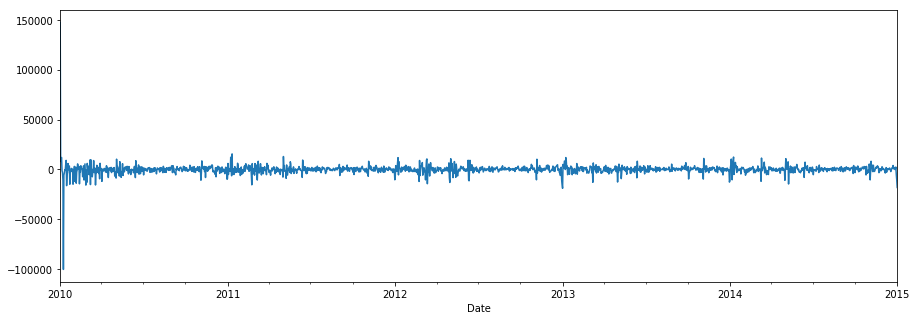

In [30]:
# plot residuals
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax)

In [31]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=2683.7741470311544, pvalue=0.0)

In [32]:
# kpss for stationarity
from statsmodels.tsa import stattools
stat = stattools.kpss(np.array(results.resid))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % (stat[0], stat[1], stat[2], stat[3]))

The KPSS test statistic 0.371036, 
pvalue: 0.09 
maximal Lag: 25 
table distribution: {'5%': 0.463, '1%': 0.739, '2.5%': 0.574, '10%': 0.347}


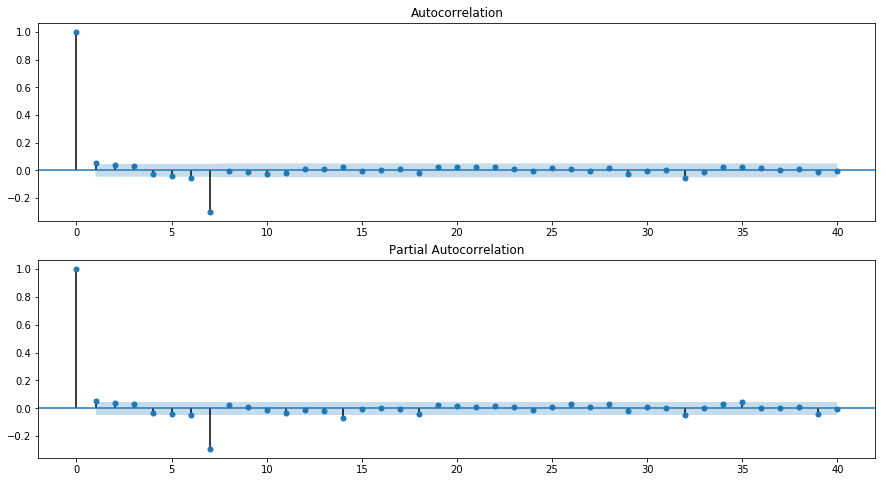

In [54]:
# ACF and PACF for residuals
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid.values.squeeze(), lags=40, ax=ax2)

Now let's do forecast, count loss and compare with real values.


In [48]:
forecast = results.predict('2015-01-01', '2015-05-27', dynamic = False)
forecast

2015-01-01    177860.183802
2015-01-02    159695.787342
2015-01-03    152035.340632
2015-01-04    151353.333071
2015-01-05    161486.579494
2015-01-06    159413.583994
2015-01-07    154547.479873
2015-01-08    147671.674561
2015-01-09    147541.918003
2015-01-10    139647.292901
2015-01-11    137888.847436
2015-01-12    147941.809909
2015-01-13    147421.294987
2015-01-14    146244.142348
2015-01-15    144590.117259
2015-01-16    144755.658077
2015-01-17    136233.746761
2015-01-18    134452.247427
2015-01-19    144483.360138
2015-01-20    144862.411660
2015-01-21    144828.650090
2015-01-22    144889.945627
2015-01-23    144934.720724
2015-01-24    136235.044141
2015-01-25    134156.783084
2015-01-26    144040.641587
2015-01-27    144619.440635
2015-01-28    145273.792369
2015-01-29    146117.233262
2015-01-30    146206.919475
                  ...      
2015-04-28    148068.445302
2015-04-29    148174.756297
2015-04-30    148287.641227
2015-05-01    148294.519242
2015-05-02    139651

In [40]:
#ts = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_en_real = ts_en.loc['2015.01.01':'2015-05-27']

ts_en_forecast = pd.DataFrame(index = ts_en_real.index)
ts_en_forecast['forecast cons'] = np.array(forecast)

qualityMACAPE(ts_en_real['EnergyConsump'],ts_en_forecast['forecast cons'])[0]

0.14971677363763411

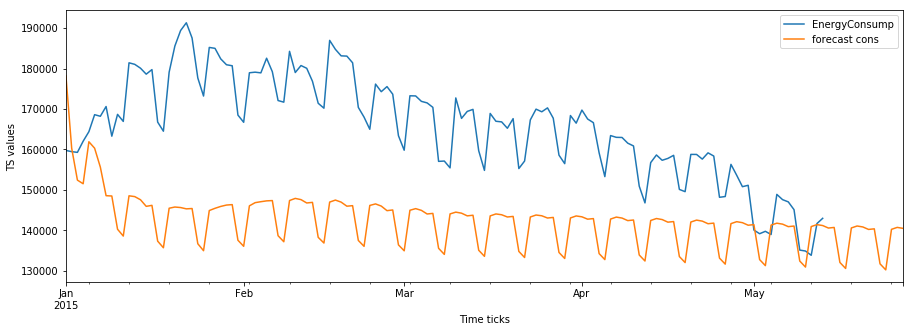

In [41]:
pd.DataFrame(ts_en_real['EnergyConsump']).merge(pd.DataFrame(ts_en_forecast['forecast cons']), right_index=True, left_index=True).plot(figsize = (15,5))

plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.show()

Now let's add exogenious variables to the models which we chosed by hand and chosed by grid search.

In [54]:
exogs = ts_en[['Temp1', 'Temp2', 'Saturday','Sunday']]
exogs_tr = exogs.loc[:'2015.01.01']

In [46]:
exogs

,Temp1,Temp2,Saturday,Sunday
Date,,,,
2010-01-01,-17.8,-16.9,0.0,1.0
2010-01-02,-17.8,-20.3,1.0,0.0
2010-01-03,-16.4,-24.0,0.0,1.0
2010-01-04,-10.2,-15.7,0.0,1.0
2010-01-05,-7.2,-8.8,0.0,1.0
2010-01-06,-8.0,-18.6,0.0,1.0
2010-01-07,-9.7,-19.5,0.0,1.0
2010-01-08,-13.3,-18.0,0.0,1.0
2010-01-09,-15.9,-22.3,1.0,0.0


In [62]:
%%time

mod = sm.tsa.statespace.SARIMAX(ts_en_cons, trend='n', order=(2,1,6), seasonal_order=(8,1,1,7), exog = exogs_tr)
results = mod.fit()
print results.summary()

                                 Statespace Model Results                                
Dep. Variable:                     EnergyConsump   No. Observations:                 1827
Model:             SARIMAX(2, 1, 6)x(8, 1, 1, 7)   Log Likelihood              -16830.490
Date:                           Fri, 09 Jun 2017   AIC                          33704.980
Time:                                   15:27:32   BIC                          33826.209
Sample:                               01-01-2010   HQIC                         33749.697
                                    - 01-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp1        -54.9252     30.159     -1.821      0.069    -114.035       4.184
Temp2        -94.5752     28.952     -3.267

We see that AIC is less than without exogenious variables, let's calculate loss.

In [66]:
forecast = results.predict('2015-01-01', '2015-05-27', dynamic = False, exog = exogs.loc['2015-01-01':'2015.05.26'])
forecast

2015-01-01    167367.129530
2015-01-02    159769.715832
2015-01-03    157704.927196
2015-01-04    161670.289647
2015-01-05    161290.223183
2015-01-06    161234.203259
2015-01-07    157533.426368
2015-01-08    153373.404829
2015-01-09    152488.481057
2015-01-10    150186.415018
2015-01-11    154323.192269
2015-01-12    153137.081229
2015-01-13    163069.710778
2015-01-14    161185.785672
2015-01-15    158937.131235
2015-01-16    158571.821610
2015-01-17    156213.067593
2015-01-18    149755.319887
2015-01-19    148192.315714
2015-01-20    159099.195772
2015-01-21    159587.500115
2015-01-22    159600.309072
2015-01-23    159678.320445
2015-01-24    156480.021008
2015-01-25    149341.409590
2015-01-26    147075.992688
2015-01-27    157014.335579
2015-01-28    156654.502653
2015-01-29    156275.994811
2015-01-30    156256.857301
                  ...      
2015-04-28    151255.742809
2015-04-29    150853.346884
2015-04-30    151309.841553
2015-05-01    151802.397926
2015-05-02    139366

In [67]:
#ts = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col='Month', parse_dates=True, dayfirst=True)
ts_en_real = ts_en.loc['2015.01.01':'2015-05-27']

ts_en_forecast = pd.DataFrame(index = ts_en_real.index)
ts_en_forecast['forecast cons'] = np.array(forecast)

qualityMACAPE(ts_en_real['EnergyConsump'],ts_en_forecast['forecast cons'])[0]

0.095596081197642124

We see that loss is less than without exogenious variables. Let's plot forecast and real values.

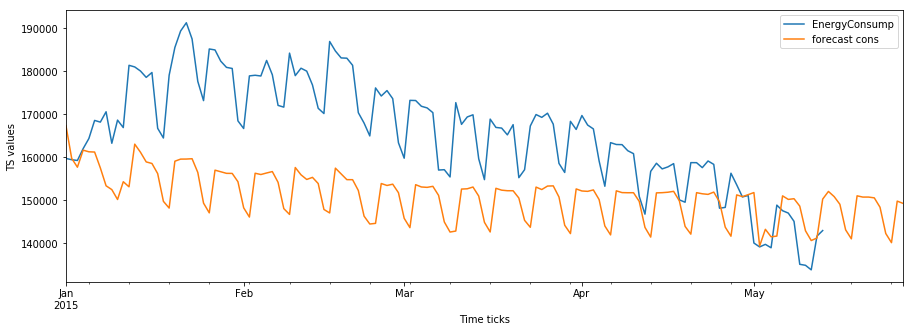

In [68]:
pd.DataFrame(ts_en_real['EnergyConsump']).merge(pd.DataFrame(ts_en_forecast['forecast cons']), right_index=True, left_index=True).plot(figsize = (15,5))

plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.show()

We see that now the forecast is closer to real values.